In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
#defining the batch_size
batch_size = 64
#Defining the transforms for the data
transform = transforms.ToTensor()

#Getting the data
train_data = datasets.MNIST('data',download=True,
                           train = True, transform = transform)

#Preparing the dataloader
train_loader = DataLoader(train_data, batch_size=batch_size,
                         shuffle = True, num_workers=0)

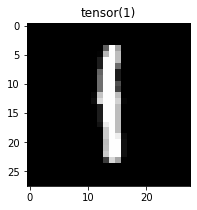

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

i = 7
img=np.squeeze(images[i])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
ax.set_title(labels[i])
plt.show()



### The model


In [14]:
class Discriminator(nn.Module):
    def __init__(self,input_size,hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size,hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2,hidden_dim)
        self.fc4 = nn.Linear(hidden_dim,output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self,x):
        
        x = x.view(-1,28*28)

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out

In [15]:
class Generator(nn.Module):
    def __init__(self,input_size,hidden_dim, output_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2,hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4,output_size)

        self.dropout = nn.Dropout(0.4)

    def forward(self,x):

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = torch.tanh(self.fc4(x))
        return out

In [16]:
# Defining the Hyperparameters.

#Discriminator Hyperparameters
d_input_size = 784
d_output_size = 1
d_hidden_dim = 32

#Generator Hyperparameters
g_input = 100
g_output = 784
g_hidden_dim  = 64


In [17]:
disc = Discriminator(d_input_size,d_hidden_dim,d_output_size)
gen = Generator(g_input,g_hidden_dim,g_output)

print(disc)
print()
print(gen)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [18]:
#Loss Functions
def real_loss(d_out,smooth = False):
    size = d_out.size(0)

    if smooth:
        labels = torch.ones(size)*0.9
    else:
        labels = torch.ones(size) 

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(),labels)
    return loss

def fake_loss (d_out):
    labels = torch.zeros(d_out.shape[0])
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(),labels)

    return loss


In [19]:
#Defining the Optimizers
lr = 0.002
d_optimizer = optim.Adam(disc.parameters(),lr)
g_optimizer = optim.Adam(gen.parameters(), lr)

## Training the 2 models.

1. First, we need to train the Discriminator model, To do that, 
    * We first need to train the discriminator on the real images
    * Generate Fake images
    * Train the model on fake images with labels = 0
    * Add the real and fake losses
    * Perform Back propagation
<br>

2. With the trained model in our hand, it is now time to train the Generator model.
    *  We generate the fake images
    * Compute the discriminator loss with the labels = 1
    * back_propagation


In [20]:
epochs = 100
print_every = 500

samples=[]
losses=[]

sample_size = 16
fixed_z = np.random.uniform(-1,1,size=(batch_size, g_input))
fixed_z = torch.from_numpy(fixed_z).float()

disc.train()
gen.train()

for epoch in range(epochs):
    for batch_i, (real_images,_) in enumerate(train_loader):
        batch_size = real_images.size(0)

        #rescaling the images:
        real_images = real_images*2 -1

        #________________Training the Discriminator________________________________

        z = np.random.uniform(-1,1,size=(batch_size, g_input))
        z = torch.from_numpy(z).float()
        fake_images = gen(z)
    
    # Generating the Real and Fake losses
        d_real = disc(real_images)
        d_fake = disc(fake_images)

        r_loss = real_loss(d_real.squeeze(),smooth=True)
        f_loss = fake_loss(d_fake.squeeze())

        d_loss = r_loss+f_loss
        d_loss.backward()
        d_optimizer.step

        d_optimizer.zero_grad()

        #_______________Training the Generator_________________

        z = np.random.uniform(-1,1,size=(batch_size, g_input))
        z = torch.from_numpy(z).float()
        fake_images = gen(z)

        d_fake = disc(fake_images)
        g_loss = real_loss(d_fake)

        g_loss.backward()
        g_optimizer.step()
        g_optimizer.zero_grad()

        #_______________Printing the stats_______________
        if batch_i %print_every ==0:
            print(f'Epoch {epoch+1}/{epochs} | Discriminator loss:{d_loss.item():.4f}| generator_loss:{g_loss.item():.4f}')
    
    losses.append((d_loss.item(), g_loss.item()))

    samples_z = gen(fixed_z)
    samples.append(samples_z)


Epoch 1/100 | Discriminator loss:1.3881| generator_loss:0.6191
Epoch 1/100 | Discriminator loss:1.3228| generator_loss:0.6715
Epoch 2/100 | Discriminator loss:1.3231| generator_loss:0.6834
Epoch 2/100 | Discriminator loss:1.3120| generator_loss:0.6868
Epoch 3/100 | Discriminator loss:1.3125| generator_loss:0.6839
Epoch 3/100 | Discriminator loss:1.3194| generator_loss:0.6880
Epoch 4/100 | Discriminator loss:1.3146| generator_loss:0.6884
Epoch 4/100 | Discriminator loss:1.3153| generator_loss:0.6873
Epoch 5/100 | Discriminator loss:1.3065| generator_loss:0.6866
Epoch 5/100 | Discriminator loss:1.3106| generator_loss:0.6995
Epoch 6/100 | Discriminator loss:1.3182| generator_loss:0.6918
Epoch 6/100 | Discriminator loss:1.3097| generator_loss:0.6868
Epoch 7/100 | Discriminator loss:1.3088| generator_loss:0.6843
Epoch 7/100 | Discriminator loss:1.3216| generator_loss:0.6779
Epoch 8/100 | Discriminator loss:1.3250| generator_loss:0.6872
Epoch 8/100 | Discriminator loss:1.3226| generator_loss

KeyboardInterrupt: 

In [22]:
disc_losses = [x[0] for x in losses]
gen_losses = [x[1] for x in losses]

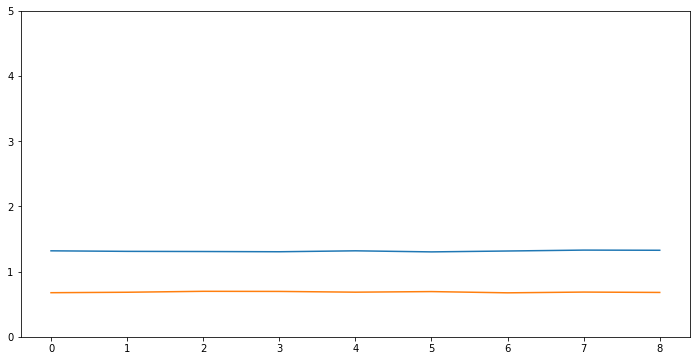

In [25]:
fig,ax = plt.subplots()
ax.plot(disc_losses,label='Discriminator Losses')
ax.plot(gen_losses,label='Generator Losses')
ax.set_ybound(lower=0.0, upper = 5.0)
fig.set_size_inches(12,6)
plt.show()


In [26]:
epochs_observed = list(range(epochs))[::4]
epochs_observed.append(39)

We have 64 digits in each sample. We are going to observe the first 5 in each epoch.

In [27]:
def view_samples(epoch,samples):
    fig,axes = plt.subplots(figsize=(14,14), nrows=1, ncols=5, sharey=True)
    for ax,img in zip(axes.flatten(),samples[epoch]):
        img = img.detach().numpy()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape(28,28), cmap='Greys') 


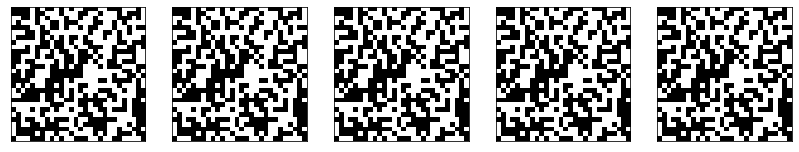

In [28]:
# for epoch in epochs_observed:
#     view_samples(epoch,samples)
view_samples(8,samples)